In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings('ignore')
import json

In [ ]:
#Leer el archivo y cargarlo en nuestra variable
df = pd.read_csv('mushrooms_cleaned.csv')

# Mostrar información básica del dataframe
print("Información del dataframe:")
print(f"Dimensiones: {df.shape}")

# Verificar si hay valores nulos
print("\nVerificando valores nulos:")
print(df.isnull().sum())

# Primeras cinco filas
df.head()

Información del dataframe:
Dimensiones: (8124, 15)

Verificando valores nulos:
class                       0
bruises                     0
odor                        0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64


,class,bruises,odor,gill-spacing,gill-size,gill-color,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,ring-type,spore-print-color,population,habitat
0,poisonous,bruises,pungent,close,narrow,black,equal,smooth,smooth,white,white,pendant,black,scattered,urban
1,edible,bruises,almond,close,broad,black,club,smooth,smooth,white,white,pendant,brown,numerous,grasses
2,edible,bruises,anise,close,broad,brown,club,smooth,smooth,white,white,pendant,brown,numerous,meadows
3,poisonous,bruises,pungent,close,narrow,brown,equal,smooth,smooth,white,white,pendant,black,scattered,urban
4,edible,no,none,crowded,broad,black,equal,smooth,smooth,white,white,evanescent,brown,abundant,grasses


In [ ]:
# 2. Preparación de los datos
# Separar características (X) y variable objetivo (y)
X = df.drop('class', axis=1)
y = df['class']

# Convertir variable objetivo a valores numéricos para facilitar la evaluación
y = y.map({'edible': 0, 'poisonous': 1})

In [ ]:
# 3. Codificación de variables categóricas usando One-Hot Encoding
# Todas las columnas son categóricas, así que las transformamos todas
categorical_features = X.columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

In [ ]:
# 4. División de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)

print(f"\nConjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

# Verificar la distribución de clases en los conjuntos de entrenamiento y prueba
print("\nDistribución de clases:")
print(f"Entrenamiento: {pd.Series(y_train).value_counts(normalize=True)}")
print(f"Prueba: {pd.Series(y_test).value_counts(normalize=True)}")


Conjunto de entrenamiento: 6093 muestras
Conjunto de prueba: 2031 muestras

Distribución de clases:
Entrenamiento: class
0    0.517971
1    0.482029
Name: proportion, dtype: float64
Prueba: class
0    0.517971
1    0.482029
Name: proportion, dtype: float64


In [ ]:
# 5. Definición de modelos
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=123))
    ]),
    'Simple Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(max_depth=3, random_state=123))
    ]),
    'Medium Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(max_depth=5, random_state=123))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=50, random_state=123))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(random_state=123, use_label_encoder=False, eval_metric='logloss'))
    ])
}

In [ ]:
# 6. Validación cruzada(10-fold)
print("\n--- Evaluación de modelos con validación cruzada (10-fold) ---")
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    print(f"{name}: Accuracy = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


--- Evaluación de modelos con validación cruzada (10-fold) ---
Logistic Regression: Accuracy = 0.9992 ± 0.0013
Simple Decision Tree: Accuracy = 0.9847 ± 0.0029
Medium Decision Tree: Accuracy = 0.9952 ± 0.0027
Random Forest: Accuracy = 1.0000 ± 0.0000
XGBoost: Accuracy = 1.0000 ± 0.0000


In [ ]:
#7. Evaluación y selección del modelo por recall
print("\n--- Evaluación detallada y selección del mejor modelo ---")

best_model_name = None
best_recall = -1
best_accuracy = -1

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, target_names=['edible', 'poisonous'])
    recall_poisonous = report['poisonous']['recall']

    print(f"\nModelo: {name}")
    print(f"Accuracy: {accuracy:.4f}, Recall venenoso: {recall_poisonous:.4f}")
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, y_pred))
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=['comestible', 'venenoso']))

    if recall_poisonous > best_recall or (recall_poisonous == best_recall and accuracy > best_accuracy):
        best_model_name = name
        best_recall = recall_poisonous
        best_accuracy = accuracy



--- Evaluación detallada y selección del mejor modelo ---

Modelo: Logistic Regression
Accuracy: 0.9985, Recall venenoso: 0.9969
Matriz de confusión:
[[1052    0]
 [   3  976]]
Reporte de clasificación:
              precision    recall  f1-score   support

  comestible       1.00      1.00      1.00      1052
    venenoso       1.00      1.00      1.00       979

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031


Modelo: Simple Decision Tree
Accuracy: 0.9867, Recall venenoso: 0.9969
Matriz de confusión:
[[1028   24]
 [   3  976]]
Reporte de clasificación:
              precision    recall  f1-score   support

  comestible       1.00      0.98      0.99      1052
    venenoso       0.98      1.00      0.99       979

    accuracy                           0.99      2031
   macro avg       0.99      0.99      0.99      2031
weighted avg       0.99      0.99      0.99      20

# Comparación visual de los modelos

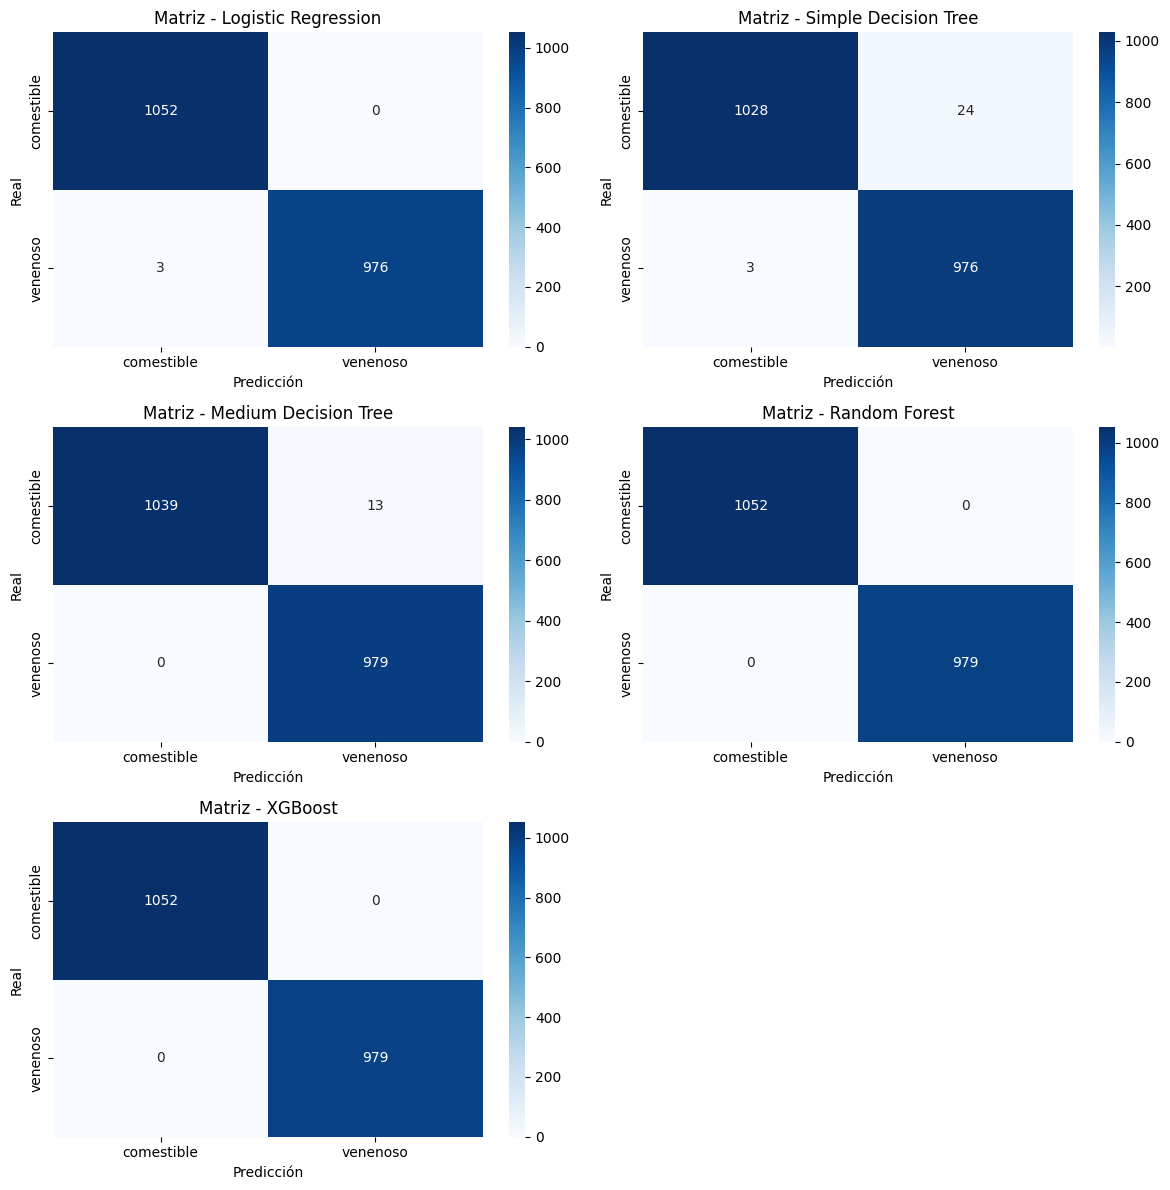

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Diccionario para guardar predicciones por modelo
model_predictions = {}

# Volvemos a predecir con cada modelo ya entrenado
for name, model in models.items():
    y_pred = model.predict(X_test)
    model_predictions[name] = y_pred

# Parámetros de visualización
model_names = list(model_predictions.keys())
num_models = len(model_names)
cols = 2  # Número de columnas en la figura
rows = (num_models + 1) // cols  # Número de filas necesarias

# Crear subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()  # Asegurarse de tener una lista de ejes

# Generar cada matriz de confusión
for idx, (name, y_pred) in enumerate(model_predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['comestible', 'venenoso'],
                yticklabels=['comestible', 'venenoso'],
                ax=axes[idx])
    axes[idx].set_title(f'Matriz - {name}', fontsize=12)
    axes[idx].set_xlabel('Predicción')
    axes[idx].set_ylabel('Real')

# Si hay más subplots que modelos, ocultamos los sobrantes
for i in range(len(model_names), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Guardar las métricas para cada modelo en un DataFrame
metrics = []

# Iterar sobre los modelos
for name, model in models.items():
    y_pred = model.predict(X_test)

    # Calcular las métricas
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, target_names=['edible', 'poisonous'])
    recall_poisonous = report['poisonous']['recall']
    f1_poisonous = report['poisonous']['f1-score']

    # Guardar las métricas
    metrics.append({
        'Modelo': name,
        'Accuracy': accuracy,
        'Recall (venenoso)': recall_poisonous,
        'F1-Score (venenoso)': f1_poisonous
    })

# Convertir las métricas a un DataFrame
metrics_df = pd.DataFrame(metrics)

# Reshape para facilitar la visualización interactiva
metrics_df = metrics_df.melt(id_vars='Modelo', value_vars=['Accuracy', 'Recall (venenoso)', 'F1-Score (venenoso)'],
                              var_name='Métrica', value_name='Valor')

# Crear el gráfico interactivo con Plotly
fig = px.bar(metrics_df, x='Modelo', y='Valor', color='Métrica',
             title="Comparación de Métricas entre Modelos",
             labels={'Valor': 'Valor de Métrica', 'Modelo': 'Modelos'},
             barmode='group', height=600)

fig.update_layout(xaxis_title="Modelos", yaxis_title="Valor de Métrica", xaxis_tickangle=-45)
fig.show()


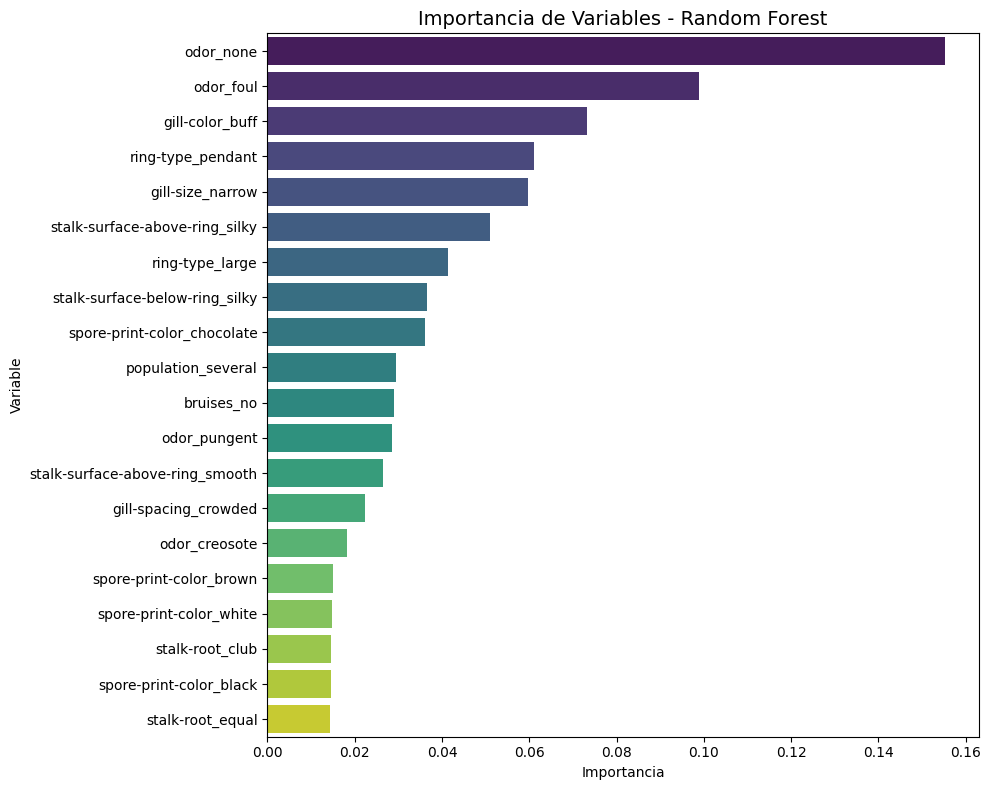

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Obtener el modelo ya entrenado
rf_pipeline = models['Random Forest']

# 2. Obtener el preprocesador y el clasificador
ohe = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
rf = rf_pipeline.named_steps['classifier']

# 3. Obtener los nombres de las variables después del OneHotEncoding
# Los nombres de columnas codificadas con drop='first' eliminaron la primera categoría
feature_names = ohe.get_feature_names_out(input_features=categorical_features)

# 4. Obtener la importancia de cada variable
importances = rf.feature_importances_

# 5. Crear un DataFrame ordenado por importancia
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 6. Gráfico de barras (solo las top N si quieres)
top_n = 20  # Número de variables más importantes a mostrar
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(top_n), y='Feature', x='Importance', palette='viridis')
plt.title('Importancia de Variables - Random Forest', fontsize=14)
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


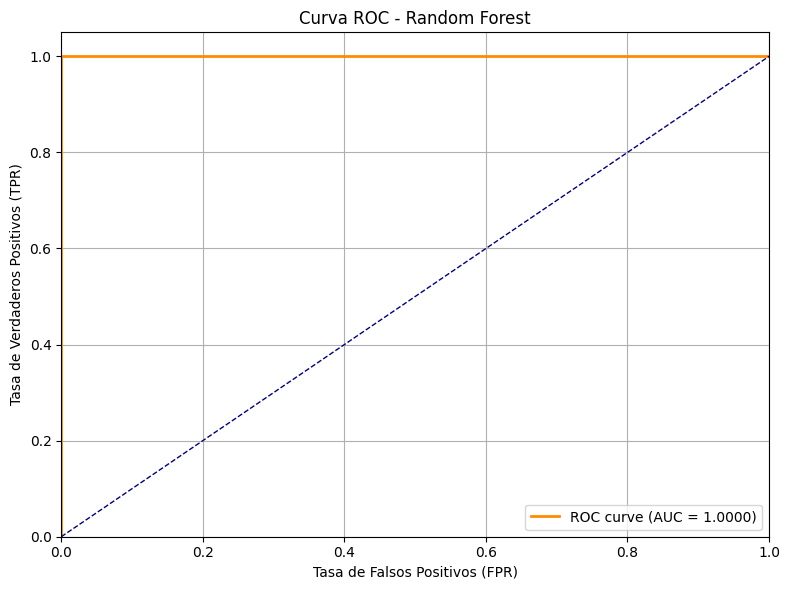

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Asegurarse de tener las probabilidades predichas
rf_model = models['Random Forest']
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # Probabilidades de clase positiva (venenoso)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')  # Línea aleatoria
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


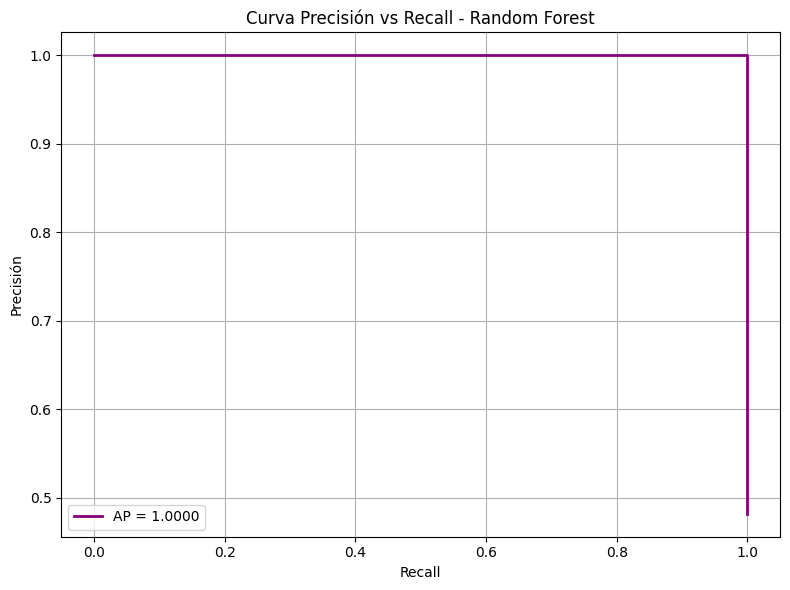

In [ ]:
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_curve, average_precision_score,
    roc_curve, auc
)
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_precision_recall_curve(y_test, y_proba_rf):
    precision, recall, _ = precision_recall_curve(y_test, y_proba_rf)
    avg_precision = average_precision_score(y_test, y_proba_rf)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='purple', lw=2, label=f'AP = {avg_precision:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    plt.title('Curva Precisión vs Recall - Random Forest')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_precision_recall_curve(y_test, y_proba_rf)

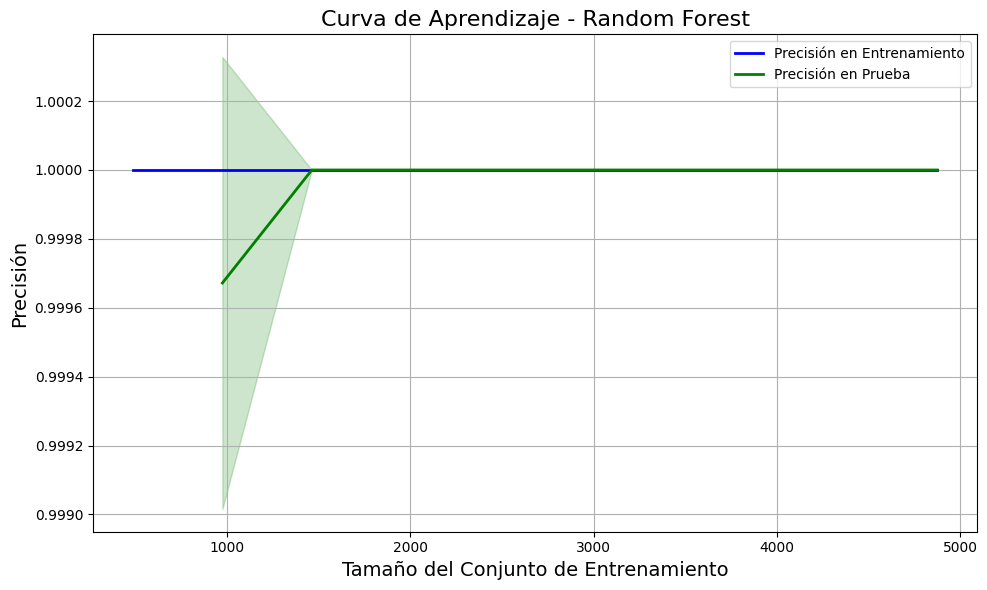

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Usar el modelo Random Forest que ya entrenaste
model_rf = models['Random Forest']

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    model_rf, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calcular la media y la desviación estándar para las puntuaciones de entrenamiento y prueba
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_std = test_scores.std(axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Precisión en Entrenamiento', color='blue', lw=2)
plt.plot(train_sizes, test_scores_mean, label='Precisión en Prueba', color='green', lw=2)

# Agregar la desviación estándar como áreas sombreadas
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='green', alpha=0.2)

# Etiquetas y título
plt.title('Curva de Aprendizaje - Random Forest', fontsize=16)
plt.xlabel('Tamaño del Conjunto de Entrenamiento', fontsize=14)
plt.ylabel('Precisión', fontsize=14)
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

plt.show()


In [ ]:
#6. GUARDAR EL MEJOR MODELO
print("\n--- Guardando el mejor modelo ---")
best_model = models[best_model_name]
with open('best_mushroom_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)
print(f"✅ Modelo '{best_model_name}' guardado como 'best_mushroom_model.pkl'")
print(f"Recall venenoso: {best_recall:.4f}, Accuracy: {best_accuracy:.4f}")


--- Guardando el mejor modelo ---
✅ Modelo 'Random Forest' guardado como 'best_mushroom_model.pkl'
Recall venenoso: 1.0000, Accuracy: 1.0000


In [ ]:
#7. Generación .json con valores posibles por columna
input_values = {col: sorted(X[col].unique().tolist()) for col in X.columns}

# Guardar como .json
with open('form_inputs.json', 'w') as f:
    json.dump(input_values, f, indent=4)

print("\n✅ Archivo 'form_inputs.json' creado con los valores posibles por campo.")


✅ Archivo 'form_inputs.json' creado con los valores posibles por campo.


In [ ]:
#8. Comprobación de posible overfitting:

print("\n--- Evaluación manual del modelo ganador con validación cruzada (depuración fold a fold) ---")

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_fold_train, y_fold_train = X.iloc[train_idx], y.iloc[train_idx]
    X_fold_test, y_fold_test = X.iloc[test_idx], y.iloc[test_idx]

    try:
        model = clone(models[best_model_name])
        model.fit(X_fold_train, y_fold_train)
        score = model.score(X_fold_test, y_fold_test)
        scores.append(score)
        print(f"Fold {fold+1}: Score = {score:.4f}")
    except Exception as e:
        print(f"❌ Fold {fold+1}: ERROR - {e}")

if scores:
    print(f"\n✅ Accuracy CV: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
else:
    print("⚠️ No se pudo calcular ningún score.")


--- Evaluación manual del modelo ganador con validación cruzada (depuración fold a fold) ---
Fold 1: Score = 1.0000
Fold 2: Score = 1.0000
Fold 3: Score = 1.0000
Fold 4: Score = 1.0000
Fold 5: Score = 1.0000
Fold 6: Score = 1.0000
Fold 7: Score = 1.0000
Fold 8: Score = 1.0000
Fold 9: Score = 1.0000
Fold 10: Score = 1.0000

✅ Accuracy CV: 1.0000 ± 0.0000


In [ ]:
#8. Demostración del modelo guardado:
print("\n--- Demostración del modelo guardado ---")
with open('best_mushroom_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

sample_indices = np.random.choice(X_test.index, size=5, replace=False)
X_samples = X_test.loc[sample_indices]
y_samples = y_test.loc[sample_indices]
y_pred_samples = loaded_model.predict(X_samples)

print("Ejemplos de predicciones:")
for i, (idx, sample) in enumerate(X_samples.iterrows()):
    true_class = "comestible" if y_samples.iloc[i] == 0 else "venenoso"
    pred_class = "comestible" if y_pred_samples[i] == 0 else "venenoso"
    print(f"Muestra {i+1}: Clase real = {true_class}, Predicción = {pred_class}")



--- Demostración del modelo guardado ---
Ejemplos de predicciones:
Muestra 1: Clase real = comestible, Predicción = comestible
Muestra 2: Clase real = comestible, Predicción = comestible
Muestra 3: Clase real = venenoso, Predicción = venenoso
Muestra 4: Clase real = venenoso, Predicción = venenoso
Muestra 5: Clase real = comestible, Predicción = comestible
